# Import the needed packages 

In [4]:
import erroranalysis as err
import auxfunctions as aux
import matplotlib.pyplot as plt

In [5]:
Z, C, W, M = aux.load_data('./data/SG_data.msgpack')
ZRef, CRef, WRef, MRef = aux.load_data('./data/SG_data_ref.msgpack')
box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45]

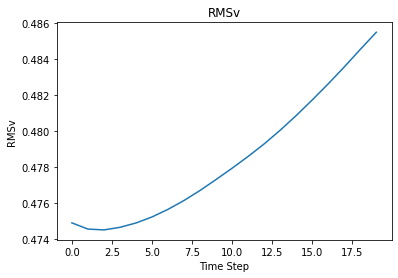

In [6]:
RMSv = err.Root_Mean_Squared_Velocity(ZRef, CRef, 'Zonal')

# Create a line plot
plt.plot(RMSv)

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('RMSv')
plt.title('RMSv')

plt.show()

In [3]:
euclid_error = err.Weighted_Euclidian_Error(Z, ZRef, MRef, 5, 3, box)

print(euclid_error)

0.0


In [ ]:
sinkhorn_loss = err.Sqrt_Sinkhorn_Loss(Z, M, ZRef, MRef, 0.001, 5, 2.5, box)

print(sinkhorn_loss)